In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import gensim
import random
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import scale
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv("Sentiment.csv")

In [3]:
df.shape

(13871, 21)

In [4]:
df.head(20)

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0000,yes,1.0000,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0000,yes,1.0000,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona
5,6,Ted Cruz,0.6332,yes,1.0000,Positive,0.6332,None of the above,1.0000,NaN,...,NaN,228,NaN,NaN,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",NaN,2015-08-07 09:54:44 -0700,629697194283499520,NaN,Central Time (US & Canada)
6,7,No candidate mentioned,1.0000,yes,1.0000,Negative,0.6761,FOX News or Moderators,1.0000,NaN,...,NaN,17,NaN,NaN,RT @warriorwoman91: I liked her and was happy ...,NaN,2015-08-07 09:54:44 -0700,629697192383672320,North Georgia,Eastern Time (US & Canada)
7,8,No candidate mentioned,1.0000,yes,1.0000,Neutral,1.0000,None of the above,1.0000,NaN,...,NaN,0,NaN,NaN,Going on #MSNBC Live with @ThomasARoberts arou...,NaN,2015-08-07 09:54:44 -0700,629697192169750528,New York NY,Eastern Time (US & Canada)
8,9,Ben Carson,1.0000,yes,1.0000,Negative,0.6889,None of the above,0.6444,NaN,...,NaN,0,NaN,NaN,Deer in the headlights RT @lizzwinstead: Ben C...,NaN,2015-08-07 09:54:44 -0700,629697190219243524,NaN,Pacific Time (US & Canada)
9,10,No candidate mentioned,0.4594,yes,0.6778,Negative,0.6778,None of the above,0.4594,NaN,...,NaN,1,NaN,NaN,RT @NancyOsborne180: Last night's debate prove...,NaN,2015-08-07 09:54:42 -0700,629697185093824512,NaN,NaN


In [5]:
df.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

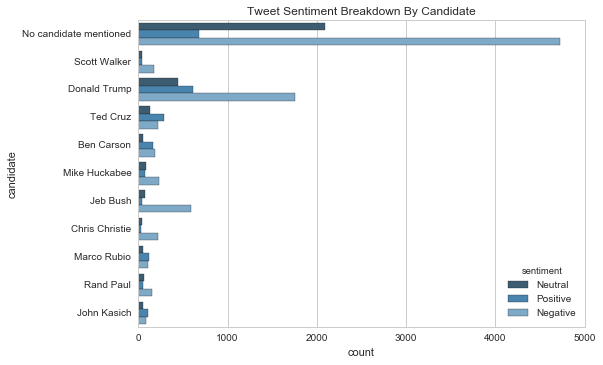

In [6]:
#Sentiment of each candidate
sns.countplot(y="candidate", hue="sentiment", data=df, palette="Blues_d");
sns.plt.title('Tweet Sentiment Breakdown By Candidate')

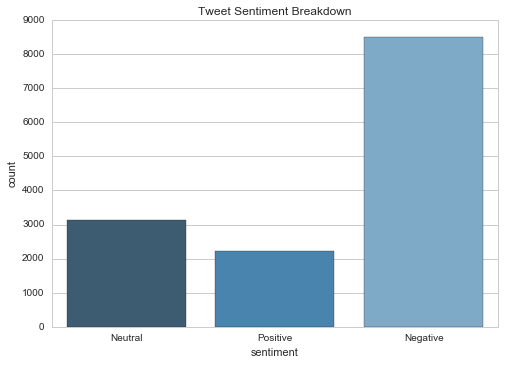

In [7]:
sns.countplot(x="sentiment", data=df, palette="Blues_d")
sns.plt.title('Tweet Sentiment Breakdown')


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df["text"],df["sentiment"], test_size=0.3)

In [9]:
def cleanText(corpus):
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]
    corpus = [z.split() for z in corpus]
    return corpus

x_train = cleanText(x_train)
x_test = cleanText(x_test)

In [10]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence

def labelize_reviews(reviews, label_type):
    labelized = []
    for i,v in enumerate(reviews):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelize_reviews(x_train, 'TRAIN')
x_test = labelize_reviews(x_test, 'TEST')

In [11]:
size = 400

#instantiate our DM and DBOW models
model_dm = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=4)
model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, dm=0, workers=4)

#build vocab over all reviews
model_dm.build_vocab(np.concatenate((x_train, x_test)))
model_dbow.build_vocab(np.concatenate((x_train, x_test)))


In [12]:
%%time
x_train = np.array(x_train)
for epoch in range(3):
    perm = np.random.permutation(x_train.shape[0])
    model_dm.train(x_train[perm])
    model_dbow.train(x_train[perm])
    
x_test = np.array(x_test)

for epoch in range(3):
    perm = np.random.permutation(x_test.shape[0])
    model_dm.train(x_test[perm])
    model_dbow.train(x_test[perm]) 

CPU times: user 6min 42s, sys: 3min 54s, total: 10min 36s
Wall time: 7min 45s


/usr/local/lib/python3.5/site-packages/gensim/models/word2vec.py:456: UserWarning: C extension compilation failed, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn("C extension compilation failed, training will be slow. Install a C compiler and reinstall gensim for fast training.")


In [13]:
def getVecs(model, corpus, size):
    vecs = [np.array(model[z.labels[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

train_vecs_dm = getVecs(model_dm, x_train, size)
train_vecs_dbow = getVecs(model_dbow, x_train, size)

test_vecs_dm = getVecs(model_dm, x_test, size)
test_vecs_dbow = getVecs(model_dbow, x_test, size)

# Initial results

In [14]:
#Stochastic Gradient Descent Classifier trained on training data for distributed memory and distributed bag of words
intial_svc_dm = SVC(kernel="linear")
intial_svc_dm.fit(train_vecs_dm, y_train)

print('Accuracy for Distributed Memory : %.2f'%intial_svc_dm.score(test_vecs_dm, y_test))

intial_svc_dbow = SVC(kernel="linear")
intial_svc_dbow.fit(train_vecs_dbow, y_train)

print('Accuracy for Distributed Bag Of Words : %.2f'%intial_svc_dbow.score(test_vecs_dbow, y_test))

Accuracy for Distributed Memory : 0.61
Accuracy for Distributed Bag Of Words : 0.61


# Scaling vectors

In [15]:
#Scale the vectors 
scaled_train_vecs_dm = scale(train_vecs_dm)
scaled_train_vecs_dbow = scale(train_vecs_dbow)
scaled_test_vecs_dm = scale(test_vecs_dm)
scaled_test_vecs_dbow = scale(test_vecs_dbow)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


# Oversampling and Undersampling

In [16]:
#Over and undersampling models to fight class imbalance
ros = RandomOverSampler()

ros_dm_y_train = y_train
ros_dbow_y_train = y_train
ros_scaled_train_vecs_dm = scaled_train_vecs_dm
ros_scaled_train_vecs_dbow = scaled_train_vecs_dbow


ros_scaled_train_vecs_dm, ros_dm_y_train = ros.fit_sample(ros_scaled_train_vecs_dm, ros_dm_y_train)
ros_scaled_train_vecs_dbow, ros_dbow_y_train = ros.fit_sample(ros_scaled_train_vecs_dbow, ros_dbow_y_train)

In [17]:
%%time
print("Distributed Memory - Oversampling")
print("-------------------------")
scaledROS_svc_dm = SVC(kernel="linear")

scaledROS_svc_dm_score = cross_val_score(scaledROS_svc_dm, ros_scaled_train_vecs_dm ,ros_dm_y_train , cv=10 )

print("Accuracy: %0.2f (+/- %0.2f)" % (scaledROS_svc_dm_score.mean(), scaledROS_svc_dm_score.std() * 2))

    
print("***********************************")
print("***********************************")
    
print("Distributed Bag of Words - Oversampling")
print("-------------------------")
scaledROS_svc_dbow = SVC(kernel="linear")

scaledROS_svc_dbow_score = cross_val_score(scaledROS_svc_dbow, ros_scaled_train_vecs_dbow ,ros_dbow_y_train , cv=10 )

print("Accuracy: %0.2f (+/- %0.2f)" % (scaledROS_svc_dbow_score.mean(), scaledROS_svc_dbow_score.std() * 2))

Distributed Memory - Oversampling
-------------------------
Accuracy: 0.51 (+/- 0.03)
***********************************
***********************************
Distributed Bag of Words - Oversampling
-------------------------
Accuracy: 0.51 (+/- 0.03)
CPU times: user 4h 23min 21s, sys: 1min, total: 4h 24min 21s
Wall time: 6h 29min 42s


In [18]:
#Fit both DM and DBOW model vectors to several classifiers after scaling, oversampling and print scores
rus = RandomUnderSampler()

rus_dm_y_train = y_train
rus_dbow_y_train = y_train
rus_scaled_train_vecs_dm = scaled_train_vecs_dm
rus_scaled_train_vecs_dbow = scaled_train_vecs_dbow

rus_scaled_train_vecs_dm, rus_dm_y_train = rus.fit_sample(rus_scaled_train_vecs_dm, rus_dm_y_train)
rus_scaled_train_vecs_dbow, rus_dbow_y_train = rus.fit_sample(rus_scaled_train_vecs_dbow, rus_dbow_y_train)


In [19]:
%%time
print("Distributed Memory - Undersampling")
print("-------------------------")
scaledRUS_svc_dm = SVC(kernel="linear")

scaledRUS_svc_dm_score = cross_val_score(scaledRUS_svc_dm, rus_scaled_train_vecs_dm ,rus_dm_y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scaledRUS_svc_dm_score.mean(), scaledRUS_svc_dm_score.std() * 2))

    
print("***********************************")
print("***********************************")
    
print("Distributed Bag of Words - Undersampling")
print("-------------------------")
scaledRUS_svc_dbow = SVC(kernel="linear")

scaledRUS_svc_dbow_score = cross_val_score(scaledRUS_svc_dm, rus_scaled_train_vecs_dbow ,rus_dbow_y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scaledRUS_svc_dbow_score.mean(), scaledRUS_svc_dbow_score.std() * 2))

Distributed Memory - Undersampling
-------------------------
Accuracy: 0.47 (+/- 0.06)
***********************************
***********************************
Distributed Bag of Words - Undersampling
-------------------------
Accuracy: 0.46 (+/- 0.05)
CPU times: user 16min 14s, sys: 2.94 s, total: 16min 17s
Wall time: 2h 51min 11s


# Hyper-tuning Parameters

In [20]:
'''%%time
hyper_svc_dm = SVC(kernel="linear")

C_param = [1, 10, 100]
gamma_param = [0.001, 0.0001]

param_grid = dict(C=C_param, gamma=gamma_param)

clf = GridSearchCV(hyper_svc_dm, param_grid, cv=5, scoring='accuracy', verbose=5)

clf.fit(train_vecs_dm, y_train)

print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)
'''

'%%time\nhyper_svc_dm = SVC(kernel="linear")\n\nC_param = [1, 10, 100]\ngamma_param = [0.001, 0.0001]\n\nparam_grid = dict(C=C_param, gamma=gamma_param)\n\nclf = GridSearchCV(hyper_svc_dm, param_grid, cv=5, scoring=\'accuracy\', verbose=5)\n\nclf.fit(train_vecs_dm, y_train)\n\nprint(clf.best_score_)\nprint(clf.best_params_)\nprint(clf.best_estimator_)\n'

In [21]:
from sklearn.metrics import f1_score

f1_svm = SVC(kernel="linear")
f1_svm.fit(train_vecs_dm, y_train)
f1_y_pred = f1_svm.predict(test_vecs_dm)

averages = ["weighted", "micro", "macro"]

for avg in averages:
    weighted = f1_score(y_test, f1_y_pred, average=avg)
    print("F1 {} score for DM: {}".format(avg, weighted))




F1 weighted score for DM: 0.4602243727196151
F1 micro score for DM: 0.6083613647284959
F1 macro score for DM: 0.25216611891245894


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
from sklearn.metrics import accuracy_score
acc_svm = SVC(kernel="linear")
acc_svm.fit(train_vecs_dm, y_train)
acc_y_pred = acc_svm.predict(test_vecs_dm)
                           
acc_weighted = accuracy_score(y_test, acc_y_pred)
print("Accuracy score for DM: {}".format(acc_weighted))
                           


Accuracy score for DM: 0.6083613647284959


In [27]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind='svm')

smote_dm_y_train = y_train
smote_dbow_y_train = y_train
smote_train_vecs_dm = train_vecs_dm
smote_train_vecs_dbow = train_vecs_dbow

smote_train_vecs_dm, smote_dm_y_train = sm.fit_sample(smote_train_vecs_dm, smote_dm_y_train)
smote_train_vecs_dbow, smote_dbow_y_train = sm.fit_sample(smote_train_vecs_dbow, smote_dbow_y_train)

In [28]:
scaled_smote_train_vecs_dm = scale(smote_train_vecs_dm)
scaled_smote_train_vecs_dbow = scale(smote_train_vecs_dbow)

In [29]:
print("Distributed Memory - SMOTE SVM")
print("-------------------------")
smote_svc_dm = SVC(kernel="linear")

smote_svc_dm_score = cross_val_score(smote_svc_dm, scaled_smote_train_vecs_dm ,smote_dm_y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (smote_svc_dm_score.mean(), smote_svc_dm_score.std() * 2))

    
print("***********************************")
print("***********************************")
    
print("Distributed Bag of Words - SMOTE SVM")
print("-------------------------")
smote_svc_dbow = SVC(kernel="linear")

smote_svc_dbow_score = cross_val_score(smote_svc_dbow, scaled_smote_train_vecs_dbow ,smote_dbow_y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (smote_svc_dbow_score.mean(), smote_svc_dbow_score.std() * 2))


Distributed Memory - SMOTE SVM
-------------------------
Accuracy: 0.62 (+/- 0.18)
***********************************
***********************************
Distributed Bag of Words - SMOTE SVM
-------------------------
Accuracy: 0.62 (+/- 0.21)


In [46]:
from sklearn.metrics import classification_report


smote_svc_dm.fit(smote_train_vecs_dm, smote_dm_y_train )
smote_svc_dm_y_pred = smote_svc_dm.predict(scaled_test_vecs_dm)

class_names = ["negative", "neutral", "positive"]
 

print(classification_report(y_test, smote_svc_dm_y_pred, target_names=class_names))

             precision    recall  f1-score   support

   negative       0.61      0.54      0.58      2532
    neutral       0.00      0.00      0.00       962
   positive       0.19      0.56      0.29       668

avg / total       0.40      0.42      0.40      4162



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
from imblearn.over_sampling import ADASYN
ada = ADASYN()

ada_dm_y_train = y_train
ada_dbow_y_train = y_train
ada_train_vecs_dm = train_vecs_dm
ada_train_vecs_dbow = train_vecs_dbow

ada_train_vecs_dm, ada_dm_y_train = ada.fit_sample(ada_train_vecs_dm, ada_dm_y_train)
ada_train_vecs_dbow, ada_dbow_y_train = ada.fit_sample(ada_train_vecs_dbow, ada_dbow_y_train)



In [31]:
scaled_ada_train_vecs_dm = scale(ada_train_vecs_dm)
scaled_ada_train_vecs_dbow = scale(ada_train_vecs_dbow)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [47]:
print("Distributed Memory - ADASYN")
print("-------------------------")
ada_svc_dm = SVC(kernel="linear")

ada_svc_dm_score = cross_val_score(ada_svc_dm, scaled_ada_train_vecs_dm, ada_dm_y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (ada_svc_dm_score.mean(), ada_svc_dm_score.std() * 2))

    
print("***********************************")
print("***********************************")
    
print("Distributed Bag of Words - ADASYN")
print("-------------------------")
ada_svc_dbow = SVC(kernel="linear")

ada_svc_dbow_score = cross_val_score(ada_svc_dbow, scaled_ada_train_vecs_dbow, ada_dbow_y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (ada_svc_dbow_score.mean(), ada_svc_dbow_score.std() * 2))

Distributed Memory - ADASYN
-------------------------
Accuracy: 0.54 (+/- 0.03)
***********************************
***********************************
Distributed Bag of Words - ADASYN
-------------------------
Accuracy: 0.52 (+/- 0.05)
